In [164]:
import utils
import cv2
import imutils
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
import skimage
from sklearn.cluster import KMeans
from collections import Counter
from scipy.spatial import distance

In [2]:
train = True

In [100]:
class ImageMerger:
    """
    ImageMerger can merge images from a dataset including images collected by a drone with the purpose of detecting 
    moving people in the images.
    """
    def __init__(self, data_dir, mask_file):
        """
        :param data_dir: path to the directory where the data is located
        :param mask_file: path of a mask which removes unneccesary text from the images
        """
        
        # Get all directories inside the data_dir
        self.data_dir = data_dir
        self.dirs = os.listdir(data_dir)
        self.mask = np.array(cv2.imread(mask_file)) // 255
        
        # Store the merged images
        self.merged_images = {}
        
    def load_images(self):
        """
        Loads the images and homographies from one directory at a time and yields them
        """
        
        for a_dir in self.dirs:
            if a_dir == 'labels.json':
                continue
            input_images = {}
            
            # Load all images in the train directory
            image_dir_file_path = os.path.join(os.path.join(self.data_dir, a_dir), '*.png')
            images = glob.glob(image_dir_file_path)
            
            # Copy all the raw images to the input images dict
            for im in images:
                file = os.path.basename(im)
                img_name = os.path.splitext(file)[0]
                src = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
                src = self.apply_mask(src)
                input_images[img_name] = src
            
            # Load the homographies json file
            homographies_file_path = os.path.join(os.path.join(self.data_dir, a_dir), 'homographies.json')
            with open(homographies_file_path, 'rb') as f:
                homographies = json.load(f)
            
            yield a_dir, input_images, homographies
        
    def apply_mask(self, image):
        """
        Applys the provided mask on image
        :param image: image file which will be treated as np.array
        """

        return image * self.mask
    
    def merge_images(self, alpha=0.75, axis=0, method='ltr', debug=False):
        """
        Merges all the images given the homographies which are retrieved from load_data. 
        :param alpha: Weighting for merging the images. The image to be merged on will be considered with a weight a alpha,
        the second image with a weight of 1-alpha.
        :param axis: defines the axis along which the images shall be merged. 0: camera axis, 1: time axis
        :param method: defines in which order the images shall be merged:
            - ltr:  The images are merged from left to right along the camera axis or from the first in time (index 0) 
                    to the last in time (index 6)
            - rtl:  The images are merged from right to left along the camera axis or from the last in time (index 6) 
                    to the first in time (index 0)
            - outl: The images are merged from the center out switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the left side/previous 
                    in time. 
            - outr: The images are merged from the center out switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the right side/next in 
                    time.
            - inl:  The images are merged from the outside inward switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the left side/previous 
                    in time. 
            - inr:  The images are merged from the outside inward switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the right side/next in 
                    time.
        :param debug: if True, results are printed to be able to debug 
        """
        
        assert method in ['ltr', 'rtl', 'outl', 'outr', 'inl', 'inr']
        
        # Define the keys and indices depending on axis and method
        keys = []
        indices = []
        if axis == 0:
            indices = range(0, 7)
            if method == 'ltr':
                keys = ['-B05', '-B04', '-B03', '-B02', '-B01', '-G01', '-G02', '-G03', '-G04', '-G05']
            elif method == 'rtl': 
                keys = ['-G05', '-G04', '-G03', '-G02', '-G01', '-B01', '-B02', '-B03', '-B04', '-B05']
            elif method == 'outl':
                keys = ['-B01', '-G01', '-B02', '-G02', '-B03', '-G03', '-B04', '-G04', '-B05', '-G05']
            elif method == 'outr':
                keys = ['-G01', '-B01', '-G02', '-B02', '-G03', '-B03', '-G04', '-B04', '-G05', '-B05']
            elif method == 'inl':
                keys = ['-B05', '-G05', '-B04', '-G04', '-B03', '-G03', '-B02', '-G02', '-B01', '-G01']
            elif method == 'inr':
                keys = ['-G05', '-B05', '-G04', '-B04', '-G03', '-B03', '-G02', '-B02', '-G01', '-B01']
        elif axis == 1:
            indices = ['-B05', '-B04', '-B03', '-B02', '-B01', '-G01', '-G02', '-G03', '-G04', '-G05']
            if method == 'ltr':
                keys = [0, 1, 2, 3, 4, 5, 6]
            elif method == 'rtl': 
                keys = [6, 5, 4, 3, 2, 1, 0]
            elif method == 'outl':
                keys = [3, 2, 4, 1, 5, 0, 6]
            elif method == 'outr':
                keys = [3, 4, 2, 5, 1, 6, 0]
            elif method == 'inl':
                keys = [0, 6, 1, 5, 2, 4, 3]
            elif method == 'inr':
                keys = [6, 0, 5, 1, 4, 2, 3]
                
        # Do the merging by looping through all indices and keys
        for a_dir, images, homographies in self.load_images():
            # Loop through the indices
            for i in indices: 
                # Load the base image depending on the method
                base_image_key = ''
                if axis == 0:
                    base_image_key = str(i) + keys[0]
                elif axis == 1:
                    base_image_key = str(keys[0]) + i
                    
                # Define the merged image and set it to the base image as the start
                merged_image = images[base_image_key]
                
                if debug:
                    print('directory: ', a_dir)
                    print('base key: ', base_image_key)

                for k in keys:
                    # Get the key given the index and k
                    key = ''
                    if axis == 0:
                        key = str(i) + k
                    elif axis == 1:
                         key = str(k) + i
                        
                    # Load the image and the corresponding homography matrix
                    im = images[key]
                    homography = np.array(homographies[key])
                    
                    # Warp the perspective (i.e. transform the current image into the perspective of the base image (-B01))
                    im_warped = cv2.warpPerspective(im, homography, im.shape[:2])
                    # Merge the images
                    merged_image = cv2.addWeighted(merged_image, alpha, im_warped, 1 - alpha, 0.0)

                self.merged_images[a_dir + '-' + str(i)] = merged_image
                
                if debug:
                    plt.imshow(merged_image)
                    plt.show()

In [101]:
image_merger = ImageMerger('../4_Notebooks/data_WiSAR/data/validation/', '../4_Notebooks/data_WiSAR/data/mask.png')
image_merger.merge_images(axis=0, method='outl', debug=False, alpha=0.75)
valid_images = image_merger.merged_images

In [102]:
image_merger = ImageMerger('../4_Notebooks/data_WiSAR/data/train/', '../4_Notebooks/data_WiSAR/data/mask.png')
image_merger.merge_images(axis=0, method='outl', debug=False, alpha=0.75)
train_images = image_merger.merged_images

In [285]:
def mahalanobis(image, threshold=4):
    array = image.copy()
    mean_vector = np.mean(array, axis=(0, 1))  
    
    im_re = array.reshape(-1, 3).astype(np.float64)
    im_re -= im_re.mean(0, keepdims=True)
    im_re_cov = 1/(im_re.shape[0]-1) * im_re.T @ im_re
        
    cov = np.linalg.inv(im_re_cov)
            
    am = array - mean_vector
    amc = am @ cov
    cdist = np.sqrt(np.einsum('ijk,ijk->ij', amc, am))
    
    anomaly = np.zeros_like(distances)    
    anomaly[cdist > threshold] = 1
        
    return distances, anomaly

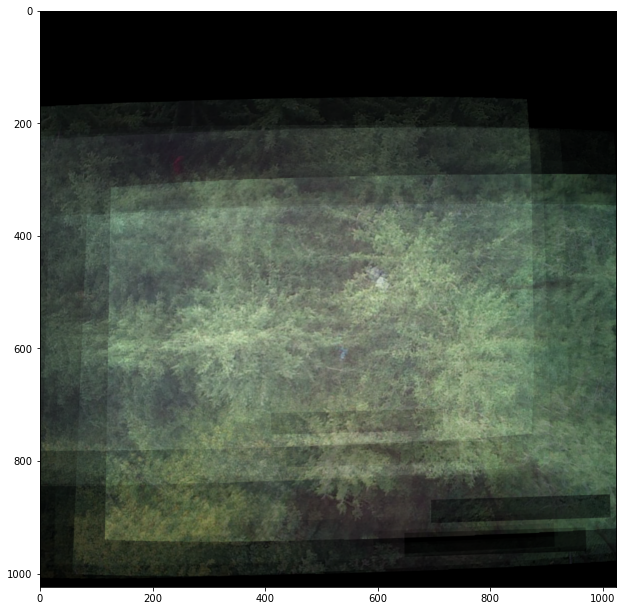

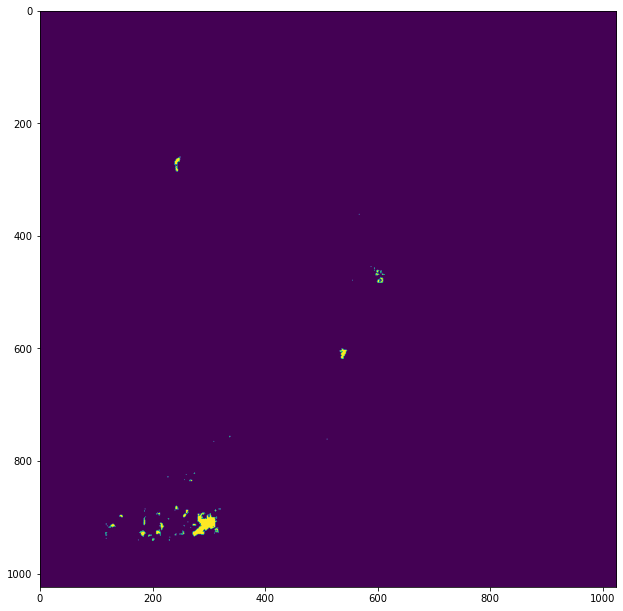

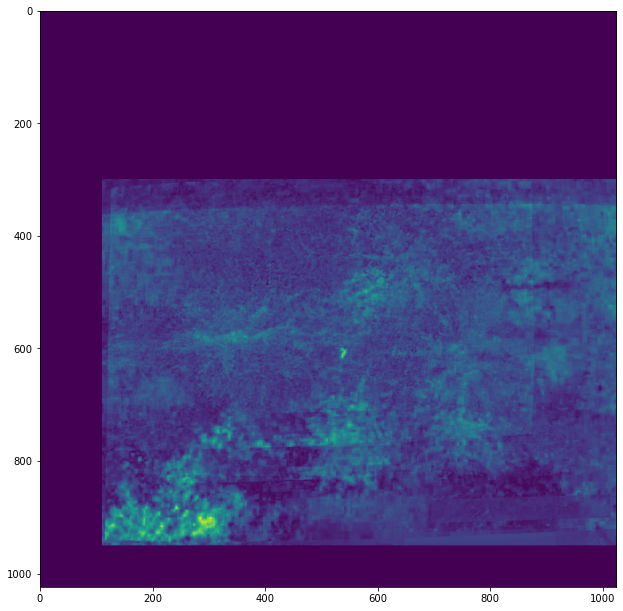

In [290]:
image = train_images['train-1-7-0']
distances, anomaly = mahalanobis(image, threshold=5)

plt.figure(figsize=(10.6, 10.6))
plt.imshow(image)
plt.figure(figsize=(10.6, 10.6))
plt.imshow(anomaly)
plt.figure(figsize=(10.6, 10.6))
plt.imshow(distances)
plt.show()

In [344]:
anomalies = []
keys = train_images.keys()

for key in keys:
    image = train_images[key]
    distances, anomaly = mahalanobis(image, threshold=5)
    anomalies.append(anomaly)

In [310]:
for i, a in enumerate(anomalies):
    anomalies[i] = torch.Tensor(cv2.resize(a, (256, 256), interpolation = cv2.INTER_AREA)).unsqueeze(0)

a0


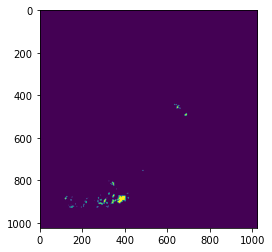

a6


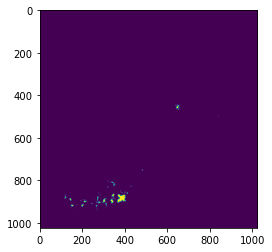

both


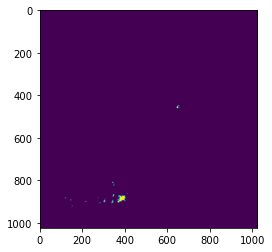

out


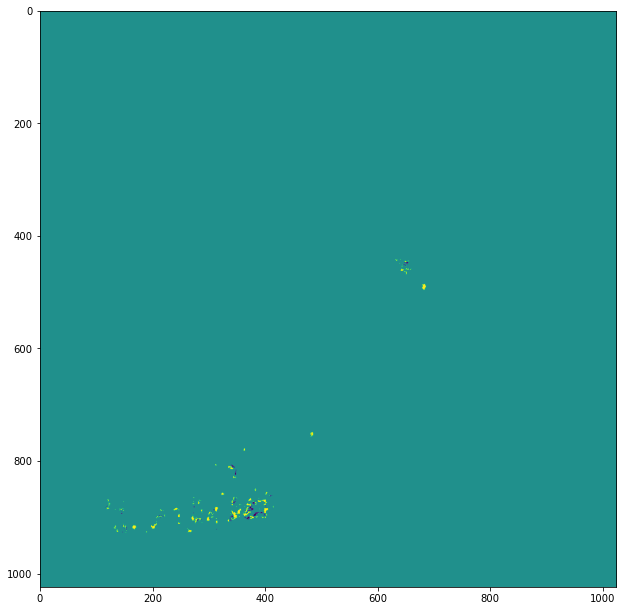

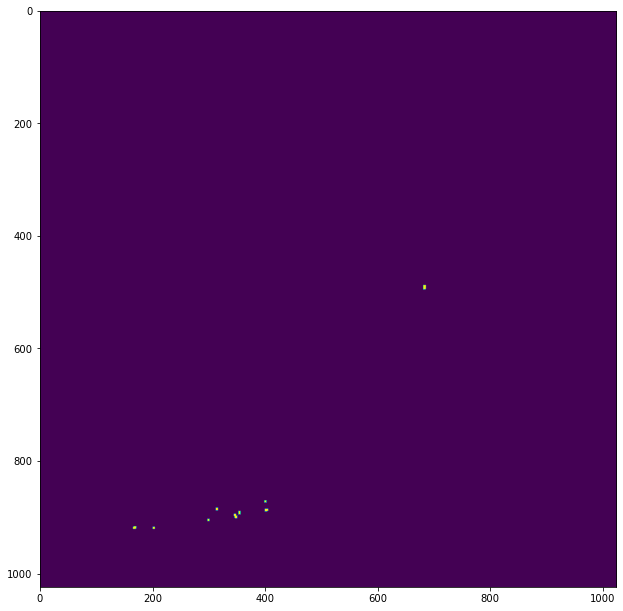

In [350]:
print('a0')
an_0 = anomalies[0]
plt.imshow(an_0)
plt.show()
print('a6')
an_6 = anomalies[6]
plt.imshow(an_6)
plt.show()
    
print('both')
both = an_0 * an_6
plt.figure(figsize=(10.6, 10.6))
plt.imshow(both)
plt.show()

print('out')
a_diff = anomalies[3] - both
plt.figure(figsize=(10.6, 10.6))
plt.imshow(a_diff)
plt.show()

kernel = np.ones((4, 4),np.uint8)
opening = cv2.morphologyEx(a_diff.astype('uint8'), cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(10.6, 10.6))
plt.imshow(opening)
plt.show()

In [330]:
img = np.array(anomalies[0].unsqueeze(0).detach().squeeze()).astype('uint8')

ret, thresh = cv2.threshold(img,0,1,0)
thresh = thresh.astype('uint8')*255
print(thresh.max())
contours, hierarchy = cv2.findContours(0, 1, 2)

print(contours)

255


error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


### rCRD

In [133]:
def rCRD_XY(image, r, l, threshold):
    image = image.swapaxes(2, 1).swapaxes(0, 1)

    d = image.shape[0]
    n = image.shape[1]*image.shape[2]
    
    X = image.copy()
    Xr = np.zeros([d, r])
    
    pts = []
                
    for i in range(r):
        x = np.random.randint(0, image.shape[1])
        y = np.random.randint(0, image.shape[2])
                
        while all(X[:, x, y] == 0) or ((y, x) in pts):
            x = np.random.randint(0, image.shape[1])
            y = np.random.randint(0, image.shape[2])
        Xr[:, i] = X[:, x, y]
        pts.append((y, x))
        
    a = Xr.T @ Xr + l
    unq, count = np.unique(a, axis=0, return_counts=True)
    b = np.linalg.pinv(Xr.T @ Xr + l) @ Xr.T
    A = (X.T @ b.T).T
    
    X_est = (A.T @ Xr.T).T
    
    diff = X - X_est
        
    delta = np.linalg.norm(diff, axis=0)
    delta = delta/np.max(delta)
    anomaly = np.where(delta > threshold, 1, 0)
    
    return anomaly

In [ ]:
image = train_images['train-1-12-0']
plt.figure(figsize=(10.6, 10.6))
plt.imshow(image)
plt.show()
image = train_images['train-1-12-0'] - mean
image = image / std
plt.figure(figsize=(10.6, 10.6))
plt.imshow(image)
plt.show()

anomaly = rCRD_XY(image, r=r, l=1e-6, threshold=t)

plt.figure(figsize=(10.6, 10.6))
plt.imshow(anomaly)
plt.show()

### Normalize images

In [132]:
keys = train_images.keys()
means = np.zeros(len(keys))   
stds = np.zeros(len(keys))

for i, key in enumerate(keys): 
    image = train_images[key]
    means[i] = image.mean()
    stds[i] = image.std()
    
mean = means.mean()
std = stds.mean()

print('Mean: %f, Standard deviation: %f' % (mean, std))

Mean: 65.088085, Standard deviation: 47.588432


In [135]:
r = 500
t = 0.7

anomalies = []

for key in keys: 
    image = train_images[key] - mean
    image = image / std
    anomaly = rCRD_XY(image, r=r, l=1e-6, threshold=t).astype('uint8')
    anomalies.append(anomaly)

print(len(anomalies))

182


In [136]:
class BinaryConvAutoEncoder(nn.Module):
    """ Convolutional auto-encoder. """
    
    def __init__(self, in_channels: int = 1, hid_channels: int = 64, code_channels: int = 256, 
                 kernel_size: int = 9, stride: int = 1, pooling: int = 2, 
                 activation: nn.Module = nn.ReLU()):
        """
        Parameters
        ----------
        in_channels : int
            Number of channels in the inputs.
        hid_channels : int
            Number of channels in the hidden layer(s).
        code_channels : int
            Number of channels in the code.
        kernel_size : int or tuple
            Window size for the convolutions
        stride : int or tuple, optional
            Window strides for the convolutions.
        pooling : int or tuple, optional
            Window size for the average pooling.
        activation : nn.Module, optional
            Activation function for the auto-encoder.
        """
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            activation,
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            activation
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, output_padding=0),
            activation,
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, output_padding=0),
            activation,
            nn.Conv2d(16, 1, kernel_size=4),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

bcae = BinaryConvAutoEncoder()

In [76]:
from torchsummary import summary

summary(bcae, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
              ReLU-2         [-1, 16, 128, 128]               0
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4            [-1, 8, 64, 64]           1,160
              ReLU-5            [-1, 8, 64, 64]               0
              ReLU-6            [-1, 8, 64, 64]               0
   ConvTranspose2d-7          [-1, 8, 129, 129]             584
              ReLU-8          [-1, 8, 129, 129]               0
              ReLU-9          [-1, 8, 129, 129]               0
  ConvTranspose2d-10         [-1, 16, 259, 259]           1,168
             ReLU-11         [-1, 16, 259, 259]               0
             ReLU-12         [-1, 16, 259, 259]               0
           Conv2d-13          [-1, 1, 256, 256]             257
          Sigmoid-14          [-1, 1, 2

In [292]:
for i, a in enumerate(anomalies):
    anomalies[i] = torch.Tensor(cv2.resize(a, (256, 256), interpolation = cv2.INTER_AREA)).unsqueeze(0)

torch.Size([1, 256, 256])


In [293]:
workers = 2
batch_size = 8

if train:
    dataset = anomalies
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

    learning_rate = 1e-3
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(bcae.parameters(), lr=learning_rate, weight_decay=1e-5)
    num_epochs = 15
    for epoch in range(num_epochs):
        loss = 0
        for batch_features in dataloader:
            im = torch.squeeze(batch_features, dim=0)
            im = nn.functional.normalize(im)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimiser.zero_grad()

            # compute reconstructions
            outputs = bcae(im)
            # compute training reconstruction loss
            train_loss = criterion(outputs, im)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimiser.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(dataloader)

        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, loss))

epoch : 1/15, loss = 0.000963
epoch : 2/15, loss = 0.000918
epoch : 3/15, loss = 0.000885
epoch : 4/15, loss = 0.000854
epoch : 5/15, loss = 0.000824
epoch : 6/15, loss = 0.000794
epoch : 7/15, loss = 0.000761
epoch : 8/15, loss = 0.000727
epoch : 9/15, loss = 0.000696
epoch : 10/15, loss = 0.000667
epoch : 11/15, loss = 0.000641
epoch : 12/15, loss = 0.000618
epoch : 13/15, loss = 0.000595
epoch : 14/15, loss = 0.000576
epoch : 15/15, loss = 0.000557


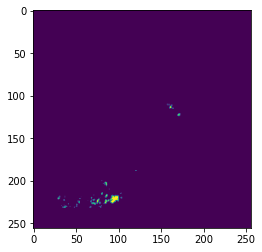

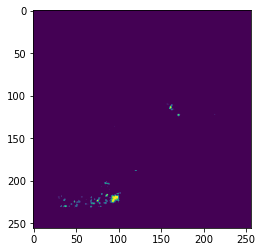

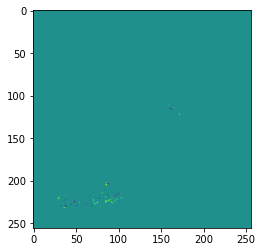

torch.Size([1, 1, 256, 256])
(256, 256)


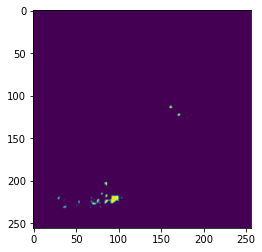

In [298]:
an_in = anomalies[0].unsqueeze(0)
an_in_2 = anomalies[1].unsqueeze(0)

an_diff = an_in - an_in_2

plt.imshow(np.array(an_in.detach().squeeze()))
plt.show()
plt.imshow(np.array(an_in_2.detach().squeeze()))
plt.show()
plt.imshow(np.array(an_diff.detach().squeeze()))
plt.show()

out = bcae(an_in)

print(out.shape)

out_d = np.array(out.detach().squeeze())

print(out_d.shape)

plt.imshow(out_d)
plt.show()